# F1tenth

In [2]:
import gym
import numpy as np



## Environment playground

In [5]:
# racecar_env = gym.make(
#     'f110_gym:f110-v0',
#     map='./f1tenth_gym/gym/f110_gym/envs/maps/vegas',
#     map_ext='.png'
# )

racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png'
)

In [4]:
obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 0.], # pose of ego
             [2., 0., 0.]])  # pose of 2nd agent
) 

obs

{'ego_idx': 0,
 'scans': [array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365]),
  array([29.98576175, 30.01263728, 29.99129338, ..., 29.99864406,
         29.9889291 , 30.01278365])],
 'poses_x': [0.0, 2.0],
 'poses_y': [0.0, 0.0],
 'poses_theta': [0.0, 0.0],
 'linear_vels_x': [0.0, 0.0],
 'linear_vels_y': [0.0, 0.0],
 'ang_vels_z': [0.0, 0.0],
 'collisions': array([0., 0.]),
 'lap_times': array([0.01, 0.01]),
 'lap_counts': array([0., 0.])}

In [5]:
state = np.concatenate([
    obs['scans'][0],
    np.array(obs['linear_vels_x'][:1]),
    np.array(obs['linear_vels_y'][:1]),
])
state.shape

(1082,)

In [6]:
speeds = np.random.rand(2, 1)*2
pi_4 = 3.1415/8
pi_2 = 3.1415/4
angles = np.random.rand(2, 1)*pi_2-pi_4
actions = np.concatenate([angles, speeds], axis=1)

actions

array([[-0.0596855 ,  0.44670051],
       [-0.05675966,  1.8354974 ]])

In [2]:
## action consists of ndarray(num_agent, 2) 0: steering angle 1: velocity
## the reward function is only for the first agent

import time
import gym 
import numpy as np


racecar_env = gym.make(
    'f110_gym:f110-v0',
    map='./f1tenth_gym/examples/example_map',
    map_ext='.png',
    num_agents=1
)
steps = 0

obs, step_reward, done, info = racecar_env.reset(
    poses=np.array([[0., 0., 1.5]]) 
) 

rewards = []

while not done:
    
    speeds = np.random.rand(2, 1)*20
    pi_4 = 3.1415/8
    pi_2 = 3.1415/4
    speeds[1][0] = 0.1
    angles = np.random.rand(2, 1)*pi_2-pi_4
    actions = np.concatenate([angles, speeds], axis=1)

    obs, step_reward, done, info = racecar_env.step(actions)
    rewards.append(step_reward)
    
    racecar_env.render()
    steps += 1
    
    if steps > 500:
        break

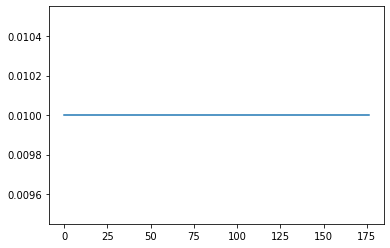

In [16]:
import matplotlib.pyplot as plt

plt.plot(rewards)

## Define environment wrapper

### waypoints

In [ ]:
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

from numba import njit

from pyglet.gl import GL_POINTS


# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t

# @njit(fastmath=False, cache=True)
def get_actuation(pose_theta, lookahead_point, position, lookahead_distance, wheelbase):
    """
    Returns actuation
    """
    waypoint_y = np.dot(np.array([np.sin(-pose_theta), np.cos(-pose_theta)]), lookahead_point[0:2]-position)
    speed = lookahead_point[2]
    if np.abs(waypoint_y) < 1e-6:
        return speed, 0.
    radius = 1/(2.0*waypoint_y/lookahead_distance**2)
    steering_angle = np.arctan(wheelbase/radius)
    return speed, steering_angle

class PurePursuitPlanner:
    """
    Example Planner
    """
    def __init__(self, conf, wb):
        self.wheelbase = wb
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        self.drawn_waypoints = []

    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

    def render_waypoints(self, e):
        """
        update waypoints being drawn by EnvRenderer
        """

        #points = self.waypoints

        points = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        
        scaled_points = 50.*points

        for i in range(points.shape[0]):
            if len(self.drawn_waypoints) < points.shape[0]:
                b = e.batch.add(1, GL_POINTS, None, ('v3f/stream', [scaled_points[i, 0], scaled_points[i, 1], 0.]),
                                ('c3B/stream', [183, 193, 222]))
                self.drawn_waypoints.append(b)
            else:
                self.drawn_waypoints[i].vertices = [scaled_points[i, 0], scaled_points[i, 1], 0.]
        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None

    def plan(self, pose_x, pose_y, pose_theta, lookahead_distance, vgain):
        """
        gives actuation given observation
        """
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, lookahead_distance, position, pose_theta)

        if lookahead_point is None:
            return 4.0, 0.0

        speed, steering_angle = get_actuation(pose_theta, lookahead_point, position, lookahead_distance, self.wheelbase)
        speed = vgain * speed

        return speed, steering_angle

def main():
    """
    main entry point
    """

    work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}
    
    with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
        conf_dict = yaml.load(file, Loader=yaml.FullLoader)
    conf = Namespace(**conf_dict)

    planner = PurePursuitPlanner(conf, 0.17145+0.15875)

    def render_callback(env_renderer):
        # custom extra drawing function

        e = env_renderer

        # update camera to follow car
        x = e.cars[0].vertices[::2]
        y = e.cars[0].vertices[1::2]
        top, bottom, left, right = max(y), min(y), min(x), max(x)
        e.score_label.x = left
        e.score_label.y = top - 700
        e.left = left - 800
        e.right = right + 800
        e.top = top + 800
        e.bottom = bottom - 800

        planner.render_waypoints(env_renderer)

    env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
    env.add_render_callback(render_callback)
    
    obs, step_reward, done, info = env.reset(np.array([[conf.sx, conf.sy, conf.stheta]]))
    env.render()

    laptime = 0.0
    start = time.time()

    while not done:
        speed, steer = planner.plan(obs['poses_x'][0], obs['poses_y'][0], obs['poses_theta'][0], work['tlad'], work['vgain'])
        obs, step_reward, done, info = env.step(np.array([[steer, speed]]))
        laptime += step_reward
        env.render(mode='human')
        
    print('Sim elapsed time:', laptime, 'Real elapsed time:', time.time()-start)

main()

### waypoint handler

In [3]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace



# @njit(fastmath=False, cache=True)
def nearest_point_on_trajectory(point, trajectory):
    """
    Return the nearest point along the given piecewise linear trajectory.

    Same as nearest_point_on_line_segment, but vectorized. This method is quite fast, time constraints should
    not be an issue so long as trajectories are not insanely long.

        Order of magnitude: trajectory length: 1000 --> 0.0002 second computation (5000fps)

    point: size 2 numpy array
    trajectory: Nx2 matrix of (x,y) trajectory waypoints
        - these must be unique. If they are not unique, a divide by 0 error will destroy the world
    """
    diffs = trajectory[1:,:] - trajectory[:-1,:]
    l2s   = diffs[:,0]**2 + diffs[:,1]**2
    # this is equivalent to the elementwise dot product
    # dots = np.sum((point - trajectory[:-1,:]) * diffs[:,:], axis=1)
    dots = np.empty((trajectory.shape[0]-1, ))
    for i in range(dots.shape[0]):
        dots[i] = np.dot((point - trajectory[i, :]), diffs[i, :])
    t = dots / l2s
    t[t<0.0] = 0.0
    t[t>1.0] = 1.0
    # t = np.clip(dots / l2s, 0.0, 1.0)
    projections = trajectory[:-1,:] + (t*diffs.T).T
    # dists = np.linalg.norm(point - projections, axis=1)
    dists = np.empty((projections.shape[0],))
    for i in range(dists.shape[0]):
        temp = point - projections[i]
        dists[i] = np.sqrt(np.sum(temp*temp))
    min_dist_segment = np.argmin(dists)
    return projections[min_dist_segment], dists[min_dist_segment], t[min_dist_segment], min_dist_segment

# @njit(fastmath=False, cache=True)
def first_point_on_trajectory_intersecting_circle(point, radius, trajectory, t=0.0, wrap=False):
    """
    starts at beginning of trajectory, and find the first point one radius away from the given point along the trajectory.

    Assumes that the first segment passes within a single radius of the point

    http://codereview.stackexchange.com/questions/86421/line-segment-to-circle-collision-algorithm
    """
    start_i = int(t)
    start_t = t % 1.0
    first_t = None
    first_i = None
    first_p = None
    trajectory = np.ascontiguousarray(trajectory)
    for i in range(start_i, trajectory.shape[0]-1):
        start = trajectory[i,:]
        end = trajectory[i+1,:]+1e-6
        V = np.ascontiguousarray(end - start)

        a = np.dot(V,V)
        b = 2.0*np.dot(V, start - point)
        c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
        discriminant = b*b-4*a*c

        if discriminant < 0:
            continue
        #   print "NO INTERSECTION"
        # else:
        # if discriminant >= 0.0:
        discriminant = np.sqrt(discriminant)
        t1 = (-b - discriminant) / (2.0*a)
        t2 = (-b + discriminant) / (2.0*a)
        if i == start_i:
            if t1 >= 0.0 and t1 <= 1.0 and t1 >= start_t:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            if t2 >= 0.0 and t2 <= 1.0 and t2 >= start_t:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break
        elif t1 >= 0.0 and t1 <= 1.0:
            first_t = t1
            first_i = i
            first_p = start + t1 * V
            break
        elif t2 >= 0.0 and t2 <= 1.0:
            first_t = t2
            first_i = i
            first_p = start + t2 * V
            break
    # wrap around to the beginning of the trajectory if no intersection is found1
    if wrap and first_p is None:
        for i in range(-1, start_i):
            start = trajectory[i % trajectory.shape[0],:]
            end = trajectory[(i+1) % trajectory.shape[0],:]+1e-6
            V = end - start

            a = np.dot(V,V)
            b = 2.0*np.dot(V, start - point)
            c = np.dot(start, start) + np.dot(point,point) - 2.0*np.dot(start, point) - radius*radius
            discriminant = b*b-4*a*c

            if discriminant < 0:
                continue
            discriminant = np.sqrt(discriminant)
            t1 = (-b - discriminant) / (2.0*a)
            t2 = (-b + discriminant) / (2.0*a)
            if t1 >= 0.0 and t1 <= 1.0:
                first_t = t1
                first_i = i
                first_p = start + t1 * V
                break
            elif t2 >= 0.0 and t2 <= 1.0:
                first_t = t2
                first_i = i
                first_p = start + t2 * V
                break

    return first_p, first_i, first_t
    
    
CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)

        
        work = {'mass': 3.463388126201571, 'lf': 0.15597534362552312, 'tlad': 1.82461887897713965, 'vgain': 0.90338203837889}

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        self.load_waypoints(conf)
        self.max_reacquire = 20.

        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
    def load_waypoints(self, conf):
        """
        loads waypoints
        """
        self.waypoints = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)

        
    def _get_current_waypoint(self, waypoints, lookahead_distance, position, theta):
        """
        gets the current waypoint to follow
        """
        wpts = np.vstack((self.waypoints[:, self.conf.wpt_xind], self.waypoints[:, self.conf.wpt_yind])).T
        nearest_point, nearest_dist, t, i = nearest_point_on_trajectory(position, wpts)
        if nearest_dist < lookahead_distance:
            lookahead_point, i2, t2 = first_point_on_trajectory_intersecting_circle(position, lookahead_distance, wpts, i+t, wrap=True)
            if i2 == None:
                return None
            current_waypoint = np.empty((3, ))
            # x, y
            current_waypoint[0:2] = wpts[i2, :]
            # speed
            current_waypoint[2] = waypoints[i, self.conf.wpt_vind]
            return current_waypoint
        elif nearest_dist < self.max_reacquire:
            return np.append(wpts[i, :], waypoints[i, self.conf.wpt_vind])
        else:
            return None
    
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):
        

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(action)
        
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        lookahead_point = self._get_current_waypoint(self.waypoints, 1.8, position, 0.9033)
        
        print(position, lookahead_point)
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        

        next_state = self.to_vector_state(obs)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()



### checkpoint handler

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(362,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=conf.wpt_rowskip)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        self.checkpoints = wps[idxs][1:]
        self.t = 0
        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800


        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
        self.next_cp_idx = 0
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        buck = 3
        scanner = np.zeros(1080//buck,)
        for i in range(1080//buck):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        scanner /= 10
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'])/5,
            np.array(obs['ang_vels_z'])
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        angle = action[0]*(np.pi/4)
#         action[1] = action[1]*5
        speed = 5
        act = np.array([[angle, speed]])
#         action = np.repeat(action, repeats=2, axis=0)
#         action[1][1] = 0
        # print(action)
        

        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
#         print(action, position)
        
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
#         if int(self.t+1) % 100 == 0:
#             print(self.t+1, position, action[0], angle)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

## Env simple wrapper

In [9]:

CAPTURE_TIME = 100
class F110Env(gym.Env):
    def __init__(self, env_config):
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(217,), dtype=np.float32)
        
        self.env = gym.make(
            'f110_gym:f110-v0',
            map='./f1tenth_gym/examples/example_map',
            map_ext='.png'
        )
        
        self.reset()
        self.prev_capture_coord = None
        
    def reset(self):
        obs, step_reward, done, info = self.env.reset(
            poses=np.array([[0., 0., 0.], 
                     [-1., -1., 0.]]) 
        )
        self.prev_capture_coord = [obs['poses_x'][0], obs['poses_y'][0]]
        self.time_to_capture = CAPTURE_TIME
        self.init_x = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):

        scanner = np.zeros(1080//5,)
        for i in range(1080//5):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*5: i*5+5]), 0, 10)

        scanner /= 10
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/5,
        ])

        return state
    
    def step(self, action):

        action[0] = action[0]*np.pi/4
        action[1] = action[1]*2.5 + 2.5
        action = action.reshape(1, 2)
        action = np.repeat(action, repeats=2, axis=0)
        action[1][1] = 0
        # print(action)
        obs, step_reward, done, info = self.env.step(action)
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -10
        
        moving_forward_rew = 0

        if self.time_to_capture == 0:
            current_coord = [obs['poses_x'][0], obs['poses_y'][0]]
            dist = abs(current_coord[0] - self.prev_capture_coord[0]) + abs(current_coord[1] - self.prev_capture_coord[1])
            # print(f"prev coord:{self.prev_capture_coord}, current_coord:{current_coord}, dist:{dist}")
            
            self.prev_capture_coord = current_coord
            if dist < 2:
                # print("Neg reward")
                moving_forward_rew = -10

            self.time_to_capture = CAPTURE_TIME + 1

        next_state = self.to_vector_state(obs)
        # ang_vel = obs['ang_vels_z'][0]
        # print(obs['ang_vels_z'][0]*0.1)
        reward += (step_reward + obs['linear_vels_x'][0]*0.01)

        self.time_to_capture -= 1
        return next_state, reward, done, info
    
    def render(self):
        self.env.render()


## Render

In [ ]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = np.array([1.0, 0.0])
    obs, reward, done, _ = env.step(action)
    env.render()

# RAY algorithms

## ppo continuous actions

In [2]:
import ray
from ray.rllib.agents import ppo, sac, ddpg

gpu_configs = {
    "num_workers": 1,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [1024, 512, 128],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}


config = {
    "num_workers": 1,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [512, 512, 128],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "render_env": False,
    },
}

ppo_config = {
    # Should use a critic as a baseline (otherwise don't use value baseline;
    # required for using GAE).
    "use_critic": True,
    # If true, use the Generalized Advantage Estimator (GAE)
    # with a value function, see https://arxiv.org/pdf/1506.02438.pdf.
    "use_gae": True,
    # The GAE (lambda) parameter.
    "lambda": 1.0,
    # Initial coefficient for KL divergence.
    "kl_coeff": 0.2,
    # Size of batches collected from each worker.
    "rollout_fragment_length": 200,
    # Number of timesteps collected for each SGD round. This defines the size
    # of each SGD epoch.
    "train_batch_size": 4000,
    # Total SGD batch size across all devices for SGD. This defines the
    # minibatch size within each epoch.
    "sgd_minibatch_size": 128,
    # Whether to shuffle sequences in the batch when training (recommended).
    "shuffle_sequences": True,
    # Number of SGD iterations in each outer loop (i.e., number of epochs to
    # execute per train batch).
    "num_sgd_iter": 30,
    # Stepsize of SGD.
    "lr": 5e-4,
    # Learning rate schedule.
    "lr_schedule": None,
    # Coefficient of the value function loss. IMPORTANT: you must tune this if
    # you set vf_share_layers=True inside your model's config.
    "vf_loss_coeff": 1.0,
    "model": {
        # Share layers for value function. If you set this to True, it's
        # important to tune vf_loss_coeff.
        "vf_share_layers": False,
    },
    # Coefficient of the entropy regularizer.
    "entropy_coeff": 0.0,
    # Decay schedule for the entropy regularizer.
    "entropy_coeff_schedule": None,
    # PPO clip parameter.
    "clip_param": 0.3,
    # Clip param for the value function. Note that this is sensitive to the
    # scale of the rewards. If your expected V is large, increase this.
    "vf_clip_param": 10.0,
    # If specified, clip the global norm of gradients by this amount.
    "grad_clip": None,
    # Target value for KL divergence.
    "kl_target": 0.01,
    # Whether to rollout "complete_episodes" or "truncate_episodes".
    "batch_mode": "truncate_episodes",
    # Which observation filter to apply to the observation.
    "observation_filter": "NoFilter",

    "num_workers": 10,
    "framework": "torch",
    "model": {
        "fcnet_hiddens": [300, 300],
        "fcnet_activation": "relu",
    },
    "evaluation_num_workers": 20,
    "evaluation_config": {
        "render_env": False,
    },
    "num_gpus": 2
}


ray.shutdown()
ray.init()
trainer = ppo.PPOTrainer(env=F110Env, config=ppo_config)

trainer.restore('./checkpoints/ppo_cp_3/checkpoint_000501/checkpoint-501')

rewards = []

for i in range(10000):

    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0:
        cp = trainer.save("./ppo_retrain_cp")
        print("checkpoint saved at", cp)


2022-02-23 18:47:39,250	WARNING trainer.py:2279 -- You have specified 20 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-02-23 18:47:39,250	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-23 18:47:39,251	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=11951) 2022-02-23 18:47:45,528	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=11966) 2022-02-23 18:47:45,625	WARN

2022-02-23 18:48:10,154	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:4.0
checkpoint saved at ./ppo_retrain_cp/checkpoint_000502/checkpoint-502
episode: 1 reward:4.0
episode: 2 reward:17.0
episode: 3 reward:21.2
episode: 4 reward:21.916666666666668
episode: 5 reward:20.857142857142858
episode: 6 reward:24.57894736842105
episode: 7 reward:24.695652173913043
episode: 8 reward:25.32
episode: 9 reward:25.296296296296298
episode: 10 reward:25.466666666666665
episode: 11 reward:24.914285714285715
episode: 12 reward:25.083333333333332
episode: 13 reward:26.186046511627907
episode: 14 reward:26.177777777777777
episode: 15 reward:26.083333333333332
episode: 16 reward:25.40740740740741
episode: 17 reward:24.810344827586206
episode: 18 reward:24.688524590163933
episode: 19 reward:24.791044776119403
episode: 20 reward:24.32857142857143
episode: 21 reward:23.986486486486488
episode: 22 reward:23.873417721518987
episode: 23 reward:24.02469135802469
episode: 24 reward:24.337349397590362
episode: 25 reward:24.564705882352943
episode: 26 reward:24.86206

KeyboardInterrupt: 

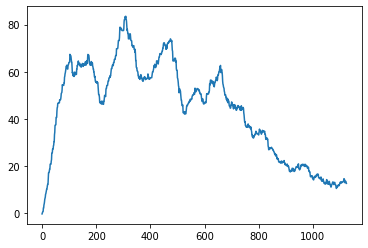

In [4]:
import matplotlib.pyplot as plt
plt.plot(rewards)

In [7]:
trainer.save("./ppo_cp_2")

'./ppo_cp_2/checkpoint_000043/checkpoint-43'

In [2]:
import ray
from ray.rllib.agents import ppo, sac, ddpg

config = {
    
    "num_workers": 0,
    "framework": "torch",
    "evaluation_num_workers": 20,
    "evaluation_config": {
        "render_env": False,
    },
    "model": {
        "fcnet_hiddens": [300, 300],
        "fcnet_activation": "relu",
    },
    "num_gpus": 0
}


trainer = ppo.PPOTrainer(env=F110Env, config=config)
trainer.restore('./checkpoints/ppo_cp_3/checkpoint_000501/checkpoint-501')

2022-02-23 18:45:37,709	WARNING trainer.py:2279 -- You have specified 20 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in order to trigger an evaluation run.
2022-02-23 18:45:38,006	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
2022-02-23 18:45:38,007	WARNING deprecation.py:45 -- DeprecationWarning: `simple_optimizer` has been deprecated. This will raise an error in the future!
2022-02-23 18:45:38,007	WARNING trainer.py:2279 -- You have specified 20 evaluation workers, but your `evaluation_interval` is None! Therefore, evaluation will not occur automatically with each call to `Trainer.train()`. Instead, you will have to call `Trainer.evaluate()` manually in or

In [9]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    


NoSuchDisplayException: Cannot connect to "None"

## discrete action

### define environment

In [1]:
import gym
import numpy as np
import time
import yaml
import gym
import numpy as np
from argparse import Namespace

    
class F110Env(gym.Env):
    def __init__(self, env_config):
        """
        break: [0., 0.]
        fast forward: [0., 5.]
        fast left: [-pi/4, 5.]
        fast right: [pi/4, 5]
        slow left: [-pi/4, 2] #later
        slow right: [pi/4, 2] 
        
        """
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(364,), dtype=np.float32)
        self.min_cp_dist = 2.0
        self.cp_reward = 1.0
        self.max_v = 5.0
        
        self.action_map = {
            0: [0., 0.],
            1: [0., self.max_v],
            2: [-np.pi/4, self.max_v],
            3: [np.pi/4, self.max_v],
            4: [-np.pi/6, self.max_v],
            5: [np.pi/6, self.max_v],
            6: [-np.pi/4, self.max_v/2], #later
            7: [np.pi/4, self.max_v/2] #later
        }
        self.action_space = gym.spaces.Discrete(len(self.action_map),)
        

        with open('./f1tenth_gym/examples/config_example_map.yaml') as file:
            conf_dict = yaml.load(file, Loader=yaml.FullLoader)
        conf = Namespace(**conf_dict)
        self.conf = conf
        wps = np.loadtxt(conf.wpt_path, delimiter=conf.wpt_delim, skiprows=0)[:, 1:3]
        idxs = [i%10 == 0 for i in range(len(wps))]
        
        self.min_x, self.max_x = np.min(wps[:,0]), np.max(wps[:, 0])
        self.min_y, self.max_y = np.min(wps[:,1]), np.max(wps[:, 1])

        self.checkpoints = wps[idxs]
        self.t = 0
        
        print(f"x and y range: {self.min_x}to{self.max_x} and {self.min_y}to{self.max_y}")
        print(f"number of waypoints:{len(self.checkpoints)}")        
        
        def render_callback(env_renderer):
            # custom extra drawing function

            e = env_renderer

            # update camera to follow car
            x = e.cars[0].vertices[::2]
            y = e.cars[0].vertices[1::2]
            top, bottom, left, right = max(y), min(y), min(x), max(x)
            e.score_label.x = left
            e.score_label.y = top - 700
            e.left = left - 800
            e.right = right + 800
            e.top = top + 800
            e.bottom = bottom - 800

        print(f"using map:{conf.map_path}")
        self.env = gym.make('f110_gym:f110-v0', map=conf.map_path, map_ext=conf.map_ext, num_agents=1)
        self.env.add_render_callback(render_callback)
        self.prev_capture_coord = None
        self.reset()
        
  
    def reset(self):
        obs, step_reward, done, info = self.env.reset(np.array([[self.conf.sx, self.conf.sy, self.conf.stheta]]))
#         obs, step_reward, done, info = self.env.reset(np.array([[0.0, 3, 1.55]]))
        
        self.next_cp_idx = 1
        self.t = 0
        return self.to_vector_state(obs)
    
    def to_vector_state(self, obs):
        scanner = obs['scans'][0]
        
        buck = 3
        size = 1080//buck
        scanner = np.zeros(size,)
        for i in range(size):
            scanner[i] = np.clip(np.mean(obs['scans'][0][i*buck: i*buck+buck]), 0, 10)
        
        scanner /= 10.0
        
        state = np.concatenate([
            scanner,
            np.array(obs['linear_vels_x'][:1])/self.max_v,
            np.array(obs['ang_vels_z'][:1])/2,
            np.array(obs['poses_x'][:1]/(self.max_x-self.min_x)),
            np.array(obs['poses_y'][:1]/(self.max_y-self.min_y))
        ])

        return state
    
    def checkpoint(self, position):
        dist = np.linalg.norm(position - self.checkpoints[self.next_cp_idx])
        reward = 0
        if dist < self.min_cp_dist:
#             print(f"Got to CP {self.next_cp_idx}")
            reward = self.cp_reward
    
            self.next_cp_idx = (self.next_cp_idx + 1)%len(self.checkpoints)
        return reward
        
    def step(self, action):

        act = np.array([self.action_map[action]])
        
        obs, step_reward, done, info = self.env.step(act)
        pose_x = obs['poses_x'][0]
        pose_y = obs['poses_y'][0]
        
        position = np.array([pose_x, pose_y])
        
        reward = 0
        if obs['collisions'][0] == 1.0:
            reward = -1
            
#         if int(self.t+1) % 100 == 0:
#             print(action)
        
        cp_reward = self.checkpoint(position)
        next_state = self.to_vector_state(obs)
        reward += cp_reward
        self.t += 1

        return next_state, reward, done, info
    
    def render(self):
        self.env.render()

F110Env({})

x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


### training

In [ ]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

ray.shutdown()
ray.init()


DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 30
DEFAULT_CONFIG['num_gpus'] = 2
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 1
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e8)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]
APEX_DEFAULT_CONFIG['final_epsilon'] = 0.1
APEX_DEFAULT_CONFIG['buffer_size'] =  1000000

# trainer = dqn.ApexTrainer(env=F110Env, config=APEX_DEFAULT_CONFIG)
trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
rewards = []

import pickle

for i in range(10000):
    result = trainer.train()
    print(f"episode: {i} reward:{result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    if i%50 == 0:
        with open('./checkpoints/ppo_disc_r2', 'wb') as f:
            pickle.dump(rewards, f)
        cp = trainer.save("./checkpoints/ppo_disc_hard_cp2")
        print("checkpoint saved at", cp)


2022-02-23 22:01:22,311	WARNING ppo.py:223 -- `train_batch_size` (4000) cannot be achieved with your other settings (num_workers=30 num_envs_per_worker=1 rollout_fragment_length=200)! Auto-adjusting `rollout_fragment_length` to 133.
2022-02-23 22:01:22,312	INFO ppo.py:249 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-02-23 22:01:22,312	INFO trainer.py:790 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(RolloutWorker pid=44330) x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
(RolloutWorker pid=44330) number of waypoints:79
(RolloutWorker pid=44330) using map:./f1tenth_gym/examples/hard
(RolloutWorker pid=44373) x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
(RolloutWorker pid=44373) number of waypoints:79
(RolloutWorker pid=44373) using map:./f1tenth_gym/examples/hard
(RolloutWorker pid=44351) x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
(RolloutWorker pid=44351) number of waypoints:79
(RolloutWorker pid=44351) using map:./f1tenth_gym/examples/hard
(RolloutWorker pid=44360) x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
(RolloutWorker pid=44360) number of waypoints:79
(RolloutWorker pid=44360) using map:./f1tenth_gym/examples/hard
(RolloutWorker pid=44353) x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
(RolloutWorker pid=44353) number of waypoints:79
(RolloutWorker pid=44353) using map:./f1tent

(RolloutWorker pid=44330) 2022-02-23 22:01:35,449	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=44373) 2022-02-23 22:01:35,489	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=44363) 2022-02-23 22:01:35,464	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=44375) 2022-02-23 22:01:35,425	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.Remo

2022-02-23 22:01:43,397	INFO trainable.py:125 -- Trainable.setup took 21.087 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-02-23 22:01:43,400	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-02-23 22:02:06,026	WARNING deprecation.py:45 -- DeprecationWarning: `clear_buffer` has been deprecated. Use `Filter.reset_buffer()` instead. This will raise an error in the future!


episode: 0 reward:1.53125
checkpoint saved at ./checkpoints/ppo_disc_hard_cp2/checkpoint_000001/checkpoint-1
episode: 1 reward:1.9344262295081966
episode: 2 reward:2.3493975903614457
episode: 3 reward:3.02
episode: 4 reward:3.81
episode: 5 reward:4.35
episode: 6 reward:5.11
episode: 7 reward:5.77
episode: 8 reward:6.23
episode: 9 reward:6.74
episode: 10 reward:6.84
episode: 11 reward:7.12
episode: 12 reward:7.87
episode: 13 reward:9.0
episode: 14 reward:9.48
episode: 15 reward:9.67
episode: 16 reward:10.61
episode: 17 reward:10.66
episode: 18 reward:11.68
episode: 19 reward:12.68
episode: 20 reward:13.27
episode: 21 reward:13.41
episode: 22 reward:14.04
episode: 23 reward:14.97
episode: 24 reward:16.05
episode: 25 reward:16.18
episode: 26 reward:16.35
episode: 27 reward:16.54
episode: 28 reward:16.41
episode: 29 reward:16.64
episode: 30 reward:16.71
episode: 31 reward:16.86
episode: 32 reward:16.77
episode: 33 reward:16.55
episode: 34 reward:16.7
episode: 35 reward:16.72
episode: 36 re

In [7]:
APEX_DEFAULT_CONFIG

{'num_workers': 32,
 'num_envs_per_worker': 1,
 'create_env_on_driver': False,
 'rollout_fragment_length': 50,
 'batch_mode': 'truncate_episodes',
 'gamma': 0.99,
 'lr': 0.0005,
 'train_batch_size': 512,
 'model': {'_use_default_native_models': False,
  '_disable_preprocessor_api': False,
  'fcnet_hiddens': [256, 256],
  'fcnet_activation': 'tanh',
  'conv_filters': None,
  'conv_activation': 'relu',
  'post_fcnet_hiddens': [],
  'post_fcnet_activation': 'relu',
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action': False,
  'lstm_use_prev_reward': False,
  '_time_major': False,
  'use_attention': False,
  'attention_num_transformer_units': 1,
  'attention_dim': 64,
  'attention_num_heads': 1,
  'attention_head_dim': 32,
  'attention_memory_inference': 50,
  'attention_memory_training': 50,
  'attention_position_wise_mlp_dim': 32,
  'attention_init_gru_gate_bias': 2.0,


(RolloutWorker pid=1477) 2022-02-19 17:34:53,395	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1486) 2022-02-19 17:34:53,556	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1506) 2022-02-19 17:34:53,728	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBaseEnv` instead. This will raise an error in the future!
(RolloutWorker pid=1480) 2022-02-19 17:34:53,666	WARNING deprecation.py:45 -- DeprecationWarning: `rllib.env.remote_vector_env.RemoteVectorEnv` has been deprecated. Use `ray.rllib.env.remote_base_env.RemoteBa

In [15]:
import ray
from ray.rllib.agents import ppo, sac, ddpg, dqn
from ray.rllib.agents.dqn.apex import APEX_DEFAULT_CONFIG
from ray.rllib.agents.ppo.ppo import DEFAULT_CONFIG

DEFAULT_CONFIG['framework'] = 'torch'
DEFAULT_CONFIG['num_workers'] = 0
DEFAULT_CONFIG['num_gpus'] = 0
DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]


APEX_DEFAULT_CONFIG['framework'] = 'torch'
APEX_DEFAULT_CONFIG['num_gpus'] = 0
APEX_DEFAULT_CONFIG['num_workers'] = 0
APEX_DEFAULT_CONFIG['exploration_config']['epsilon_timesteps'] = int(1e8)
APEX_DEFAULT_CONFIG['model']['fcnet_hiddens'] = [1024, 1024]
APEX_DEFAULT_CONFIG['final_epsilon'] = 0.1


trainer = ppo.PPOTrainer(env=F110Env, config=DEFAULT_CONFIG)
trainer.restore('./checkpoints/ppo_disc_hard_cp2/checkpoint_000051/checkpoint-51')

x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


2022-02-23 22:43:01,861	WARNING util.py:55 -- Install gputil for GPU system monitoring.
2022-02-23 22:43:01,909	INFO trainable.py:472 -- Restored on 128.205.218.23 from checkpoint: ./checkpoints/ppo_disc_hard_cp2/checkpoint_000101/checkpoint-101
2022-02-23 22:43:01,910	INFO trainable.py:480 -- Current state after restoring: {'_iteration': 101, '_timesteps_total': 805980, '_time_total': 2203.026338815689, '_episodes_total': 793}


In [17]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    action = trainer.compute_action(obs)
    obs, reward, done, _ = env.step(action)
    env.render()
    


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard


In [16]:
done = False
env = F110Env({'explore':False})
obs = env.reset()

while not done:
    policy = trainer.get_policy()
    action, _, info = policy.compute_single_action(obs)
    logits = info['action_dist_inputs']
    best_action_id = logits.argmax() # deterministic
    obs, reward, done, _ = env.step(best_action_id)
    env.render()
    


x and y range: -52.1124185to1.0823861 and -13.8182946to25.381983
number of waypoints:79
using map:./f1tenth_gym/examples/hard
